In [1]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
from shrbk.data import get_galaxy_image

# Blending bias

## Definition

Blending bias is present when working with crowded fields. It is defined as the bias that arise due to the presence of other galaxies near the one which is being measured. It can have two origins : either the neighbour galaxies directly impact the measured shape, or if blended galaxies are removed from the sample it may give rise to a selection bias.

## Shape measurement impact through examples

Here we will show the impact of unrecognized blends on shape measurement. For simplicity, we will use a simple exponential profil for galaxies, and apply shear to each of the galaxies. We also convolve the galaxies with a simple Moffat PSF profile. 

### Unblended case

First we generate a central galaxy, whose shape will be measured using the KSB method. It will be used as a reference to compare with the cases where there is actual blending.

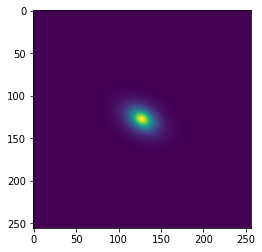

Shear measurement results : g1 =  0.10282425582408905 , g2 =  0.20562252402305603


In [2]:
image_central, image_psf = get_galaxy_image(gal_flux=1.e5,gal_r0=1.4,g1=0.1,g2=0.2,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2)

plt.imshow(image_central.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(image_central,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

Then we generate a companion galaxy with which it will be blended.

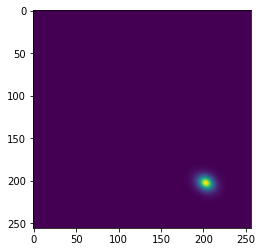

In [3]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=0.1,g2=0.2,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=15,shift_y=15)

plt.imshow(image_companion.array)
plt.show()

We will first generate a scene where the two galaxies are far apart from each other. Observe that the shape measurement is unaffected by the presence of the companion galaxy.

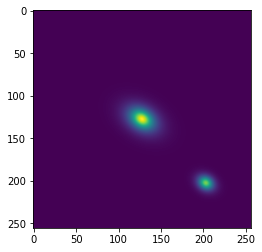

Shear measurement results : g1 =  0.10282425582408905 , g2 =  0.20562253892421722


In [4]:
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

If we plot the light profile of the image along the x axis, we can see that the two profiles are completely separated here.

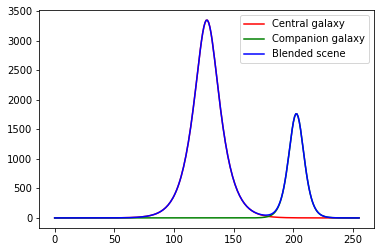

In [5]:
profile_central = np.sum(image_central.array, axis=0)
profile_companion = np.sum(image_companion.array, axis=0)
profile_blended = np.sum(blended_scene.array, axis=0)
plt.plot(list(range(256)),profile_central,color="red",label="Central galaxy")
plt.plot(list(range(256)),profile_companion,color="green",label="Companion galaxy")
plt.plot(list(range(256)),profile_blended,color="blue",label="Blended scene")
plt.legend()
plt.show()

### Blended case

Now, we will generate a scene where the galaxies truly overlap each other. We regenerate the image of the companion galaxy closer to the central one.

In [6]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=0.1,g2=0.2,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=5,shift_y=6)

We can now carry the measurement on the blended image. Notice how the measurement is largely affected by the presence of the companion galaxy near the central one.

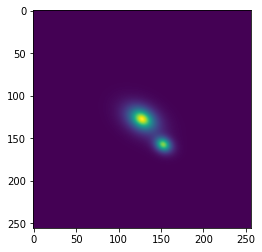

Shear measurement results : g1 =  0.06954797357320786 , g2 =  0.29567399621009827


In [7]:
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

We can plot again the light profile and see how the profiles overlap : there are no longer two separate peaks but instead only one with two "subpeaks".

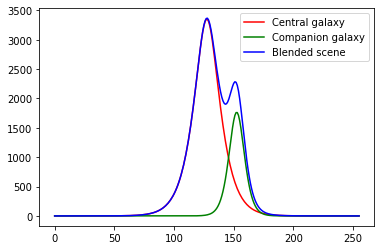

In [8]:
profile_central = np.sum(image_central.array, axis=0)
profile_companion = np.sum(image_companion.array, axis=0)
profile_blended = np.sum(blended_scene.array, axis=0)
plt.plot(list(range(256)),profile_central,color="red",label="Central galaxy")
plt.plot(list(range(256)),profile_companion,color="green",label="Companion galaxy")
plt.plot(list(range(256)),profile_blended,color="blue",label="Blended scene")
plt.legend()
plt.show()

### Blended case with different shear
Bias due to blended galaxies is hard to estimate, as it not only depends on the presence of the neighbour but also on its shear, which may be different if the two galaxies are situated at different redshifts. We can see it by modifying the shear of the companion galaxy in the previous scene.

In [9]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=5,shift_y=6)

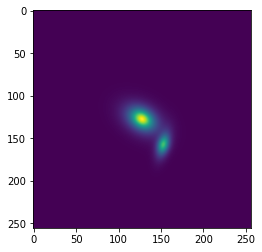

Shear measurement results : g1 =  0.10958495736122131 , g2 =  0.2798094153404236


In [10]:
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

plt.imshow(blended_scene.array)
plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

### Basic deblending example

One of the ways of dealing with the problem is called "deblending", ie trying to separate the images of the different galaxies and perform shape measurement on those images. The software Source Extractor ({cite}`SExtractor`) offers a way to do that, by assigning each pixel to a source, which of course is not a perfect solution but is relatively easy to implement. Here is what the result looks like, using the package sep ({cite}`Barbary2016`), a python implementation of Source Extractor.

In [11]:
import sep
img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)

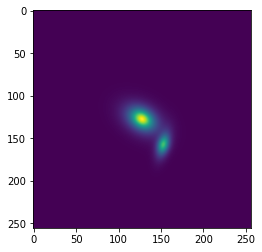

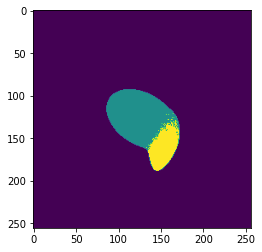

In [12]:
plt.imshow(blended_scene.array)
plt.show()
plt.imshow(segmentation)
plt.show()


To perform the measurement, we may mask the companion galaxy using the segmentation. You can see that in this case this was enough to recover an accurate estimate of the shear ; however this is not always the case, hence the need for more powerful deblending algorithms.

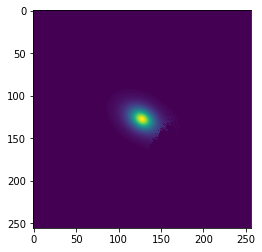

Shear measurement results : g1 =  0.10152844339609146 , g2 =  0.19612617790699005


In [13]:
masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
plt.imshow(masked_scene)
plt.show()
measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)

## Quantifying blending bias

To date, many weak lensing analysis have been carried using only very basic deblending solutions, eg Source Extractor, or rejecting altogether blended samples. However, this approach will become impractical with next generation surveys, as they are deeper than the previous one, resulting in more galaxies being detected leading to more blending ; according to {cite}`Bosch2018`, 58% of the HSC detections correspond to blended objects.

Some papers have analyzed the bias due to blending : 
- {cite}`Sheldon2020` present a modification of <span style="font-variant:small-caps;">Metacalibration</span> to calibrate specifically for blending bias, called <span style="font-variant:small-caps;">Metadetection</span> ; in the paper they obtain a -3.5% for LSST Y10 simulations using the standard <span style="font-variant:small-caps;">Metacalibration</span>, and only -0.15% using <span style="font-variant:small-caps;">Metadetection</span> . They also measured the multiplicative bias as a function of the distance separating the blended galaxies ; they report that the main point of failure both for <span style="font-variant:small-caps;">Metacalibration</span> and <span style="font-variant:small-caps;">Metadetection</span>  is at intermediate distances (1.5 arcseconds), when the blending is ambiguous, meaning that the objects are sometimes identified as two objects and sometimes only one by the detection algorithm (<span style="font-variant:small-caps;">Metadetection</span> is still much better than <span style="font-variant:small-caps;">Metacalibration</span> at this scale). Please note that the simulations from this paper use the same shear for all the sources and thus do not account for the possible bias due to different shears for different redshifts.
- {cite}`DESY3Blending` establishes a formal framework for dealing with blended galaxies at different redshifts, assuming that they may have different shear. In constant shear simulation, using <span style="font-variant:small-caps;">Metacalibration</span> for shape measurement, they report a multiplicative bias of around -2% in their fiducial simulation, dropping to -0.4% in a simulation where no objects are blended. They also show that a having blended objects with a different shear (corresponding to the case where the objects are at different redshifts) induce a bias in the <span style="font-variant:small-caps;">Metacalibration</span> measurement.  
- {cite}`Dawson2016` has tried to estimate the impact of blending in real data from HSC, using HST higher resolution data to identify ambiguous blends (when only one object is detected). They estimate, using conservative assumptions, that those undetected blends increase the measured shear variance by (1) increasing the variance of the galaxy ellipticities and (2) decreasing the total number of observed objects. They find an increase in the shear noise of 14% when considering galaxies up to magnitude 27, and by 7% when limiting the magnitude to 25.3 (corresponding to the LSST "Gold" Sample).
- {cite}`Mandelbaum2018` presents calibration experiments for HSC, using HST data from the COSMOS catalog for simulating HSC images. Using two different samples, one removing the neighbours and the other keeping them, they identify a multiplicative bias due to blending ranging from -4% to -10%. They also show how cutting at a higher magnitude increases the multiplicative bias due to blending.

## Selection bias due to blending

One of the ways to avoid dealing with blended galaxies is to reject them before carrying shape measurement. While we have seen in the previous section that this is not a good idea for new surveys due to the very large proportion of blended galaxies, it may also be a source of bias in previous weak lensing analysis, inducing a selection bias.

Namely, {cite}`Hartlap2011` describe two effects of rejecting blended galaxies. First, the redshift distribution is modified : galaxies at low redshift tend to be larger and are thus more prone to blending, meaning that rejecting them leads to a shift in the distribution towards higher redshifts. The second effect is more severe : the rejection of galaxy is density dependent, as an higher density of matter tends to lead to more galaxies, and thus more blending and more rejected galaxies. The opposite is true in underdense regions. This can induce a bias as high as a few percents on shear correlation statistics, potentially having large consequences on the results of weak lensing analysis.